# Description
In this proposal, we have empirically taken our basket of ESG Investments with two different risk-based allocations Equally Weighted (EW) and Minimum Volatility (MV). The idea of this multi- allocation is to test which can offer a better risk-performance for our basket considering the period.

The back-testing setup considers 146 monthly periods that correspond from 10.2007 to 03.2020. It is essential to mention that the asset allocation process is rebalanced monthly and considered as in-sample-data 50 months for the asset allocation process as well. The process was automatized by the software Jupyther-Python. All portfolios are long-only and full invested. 



# Minimum Volatility
The literature define as the Global Minimum Volatility Portfolio that a professional investor can get in the efficient frontier finding the portfolio with the lowest volatility.

In this structured product, we found it more useful to see the portfolio allocation with which we can get the lowest volatility by defining a certain return target instead of finding an optimal portfolio that minimizes the volatility.


# How the code works?
Well, you just need to upload the direction of the file called "Prices_Monthly". I dowloaded the monthly prices of 77 ESG Assets from Reuters (I had attached this excel as well).

# Main Modules

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew
from scipy.optimize import minimize

# Function Minimize Volatility

In [262]:
def minimize_vol(target_return, er, cov):
    """from a target return to a weight vector"""
    n = er.shape[0]
    init_guess= np.repeat(1/n, n) #started point equally weighted
    bounds= ((0.0, 0.15),)*n #defined the bounds of each asset between 0 as a min. and 15% max weights
    return_is_target= {
        'type': 'eq',
        'args': (er,),
        'fun': lambda weights, er: target_return - portfolio_return(weights,er) #defining the contrainst that  Target return -E(r)=0
    }
    weights_sum_to_1 = {
        'type': 'eq',
        'fun': lambda weights: np.sum(weights)-1 #defining the contrainst that sum(weights)-1=0
    }
    results = minimize(portfolio_vol, init_guess,  # min the vol of the portfolio with the restrictions defined in the code above
                       args=(cov,),method= "SLSQP",
                       options={'disp': False},
                       constraints= (return_is_target, weights_sum_to_1),
                       bounds=bounds
                      ) 
    return results.x

def portfolio_vol(weights, covmat): #return the volatility of the porftolio given the parameter weights and cov
    return (np.dot(np.dot(weights.T, covmat),weights))**0.5

def portfolio_return(weights, returns): #returns the portfolio return given the weights and returns as a parameter
    return np.dot(weights.T, returns)

# Main Code

In [264]:
num_in_sample=50 #generating the optimal weights based on 50 months data
ind= pd.read_csv('C:/Users/Rafael/data/Prices_Monthly.csv', header=0, index_col=0) 
#ATTENTION: here you just need to upload the direction of the file "Prices_Monthly" I took it from Reuters

ret_ew_hist=[] # I defined these lists because I wanna get the historical returns & weights of the two asset allocation
wgt_minVol_hist=[]
ret_minVol_hist=[]
w_ew=1.0/77 #for equally weighted portfolio

for i in range(num_in_sample,len(ind)+1): 
    #this for gives me the alternative to do a dynamic asset allocation through 50 months for each iteration
    start_point=i-num_in_sample
    dynamic_data=ind[start_point: i]
    cov= dynamic_data.cov()
    er = dynamic_data.mean()
    
    w15= minimize_vol(0.015, er, cov)# I defined a target of 1.5% return
    wgt_minVol_hist= np.append(wgt_minVol_hist, w15)  #adding rows to the historic array
    
  
    #once we have the optimal weights in t, we will test the asset allocation obtained in t+1 using the returns in t+1.
    returns_plusone=ind[i:i+1]
    
    
    portfolio_return_ew= (w_ew*returns_plusone)
    portfolio_return_ew= portfolio_return_ew.sum(axis=1)
    portfolio_return_minVol= (w15*returns_plusone)
    portfolio_return_minVol= portfolio_return_minVol.sum(axis=1)
    
    
    ret_ew_hist= np.append(ret_ew_hist, portfolio_return_ew)  #adding rows to the historic array
    ret_minVol_hist= np.append(ret_minVol_hist,portfolio_return_minVol)


    
    
    
    
   




# WEALTH INDEX & RISK MEASURES




In [265]:
#calculating the index wealth
wealth_index_ew= 1000*(1+ret_ew_hist).cumprod()

wealth_index_MinVol= 1000*(1+ret_minVol_hist).cumprod()

#risk measures
print kurtosis(ret_ew_hist)
print kurtosis(ret_minVol_hist)
print skew(ret_ew_hist)
print skew(ret_minVol_hist)
print ret_ew_hist.std()
print ret_minVol_hist.std()
print ret_ew_hist.mean()
print ret_minVol_hist.mean()


    

0.406932710216
0.293498003788
-0.319153007781
-0.490748705487
0.044998390331141905
0.04173526209847986
0.007000731383313658
0.007378713123297129


# Code for fancy plots


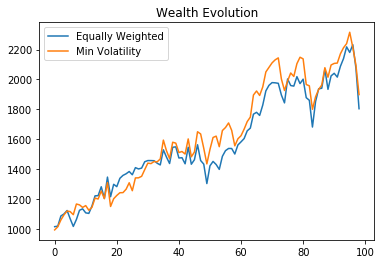

In [266]:
plt.plot(wealth_index_ew, label="Equally Weighted") 
plt.plot(wealth_index_MinVol, label= "Min Volatility")
plt.title('Wealth Evolution')
plt.legend(loc="upper left")
plt.show()
